In [52]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score


In [53]:
#Import data and choose predictors
grade_data = pd.read_excel('Grade_data/ODE_Grade_Data.xlsx')

#Keep only early grade data
early_data = grade_data[['Semester', 'HW1', 'HW2', 'HW3', 'HW4', 'Quiz1', 'Quiz2', 'Quiz3', 'Midterm1', 'M1_rel_ave']]
#Insert quiz and homework averages (normalized between 0 and 1)
early_data.insert(5, 'HW Avg',early_data[['HW1','HW2','HW3','HW4']].mean(axis=1)/10)
early_data.insert(9, 'Quiz Avg',early_data[['Quiz1','Quiz2','Quiz3']].mean(axis=1)/10)

#Choose the data to use for prediction
X = early_data[['HW Avg', 'Midterm1', 'Quiz Avg']]
#X = early_data[['M1_rel_ave', 'Quiz Avg']]
#X = X.rename(columns = {'M1_rel_ave': 'Midterm1'})

'''
#y is the target vector: 0 if the student failed, 1 if they passed
y = ((grade_data['Course Grade'] == 'A') + (grade_data['Course Grade'] == 'B') + (grade_data['Course Grade'] == 'C'))*1
'''

#y is the target vector: 0 if the student failed, 1 if they passed
y = 1 - ((grade_data['Course_Grade'] == 'D') + (grade_data['Course_Grade'] == 'F'))*1

early_data.insert(loc = len(early_data.columns), column = 'Pass', value = y)

In [54]:
early_data.head()

,Semester,HW1,HW2,HW3,HW4,HW Avg,Quiz1,Quiz2,Quiz3,Quiz Avg,Midterm1,M1_rel_ave,Pass
0,Sp22,10,0,10,10,0.75,5.0,8,7,0.666667,1.000,0.215371,1
1,Sp22,10,10,0,10,0.75,5.0,4,7,0.533333,0.725,-0.118856,1
2,Sp22,10,10,10,10,1.00,10.0,9,8,0.900000,0.900,0.093834,1
3,Sp22,10,10,10,10,1.00,9.0,5,7,0.700000,0.575,-0.301162,0
4,Sp22,10,10,10,10,1.00,6.0,10,7,0.766667,0.700,-0.149240,0


In [55]:
early_data[['HW Avg', 'Quiz Avg', 'Midterm1']].corr(numeric_only=True)

,HW Avg,Quiz Avg,Midterm1
HW Avg,1.000000,0.225561,0.096318
Quiz Avg,0.225561,1.000000,0.524909
Midterm1,0.096318,0.524909,1.000000


In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

    feature        VIF
0    HW Avg  15.618070
1  Midterm1  20.651488
2  Quiz Avg  16.926606


# Plot grade distributions 

<Axes: title={'center': 'All time'}, xlabel='Course_Grade'>

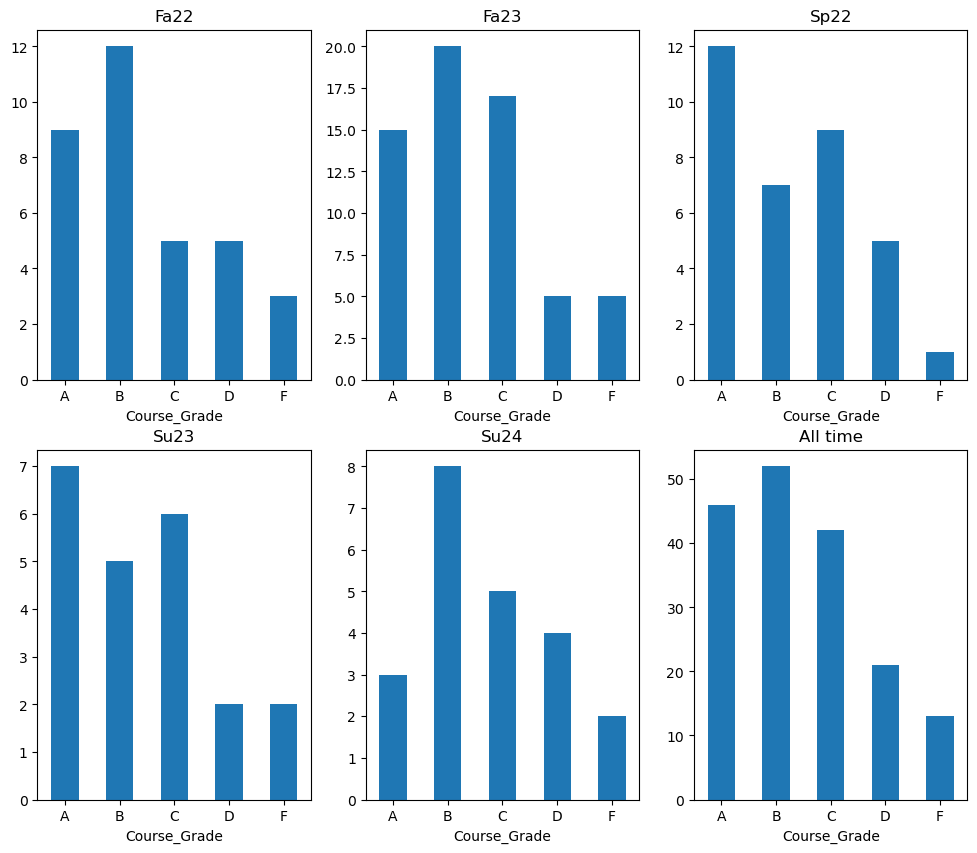

In [57]:

semesters = grade_data.groupby('Semester').Course_Grade.value_counts(sort=False).index.unique(level='Semester').tolist()

grade_hists = grade_data.groupby('Semester').Course_Grade.value_counts(sort=False)
total_grade_hist = grade_data.Course_Grade.value_counts().sort_index()

fig, axes = plt.subplots(2, 3)
for i, semester in enumerate(semesters):
    grade_hists.loc[semester].plot(kind='bar', rot=0, ax=axes[math.floor(i/3),i%3], title=semester, figsize=(12,10))
  
total_grade_hist.plot(kind='bar', rot=0, ax=axes[1,2], title='All time', figsize=(12,10))
#plt.show()

<Axes: title={'center': 'All time'}, xlabel='Course_Grade'>

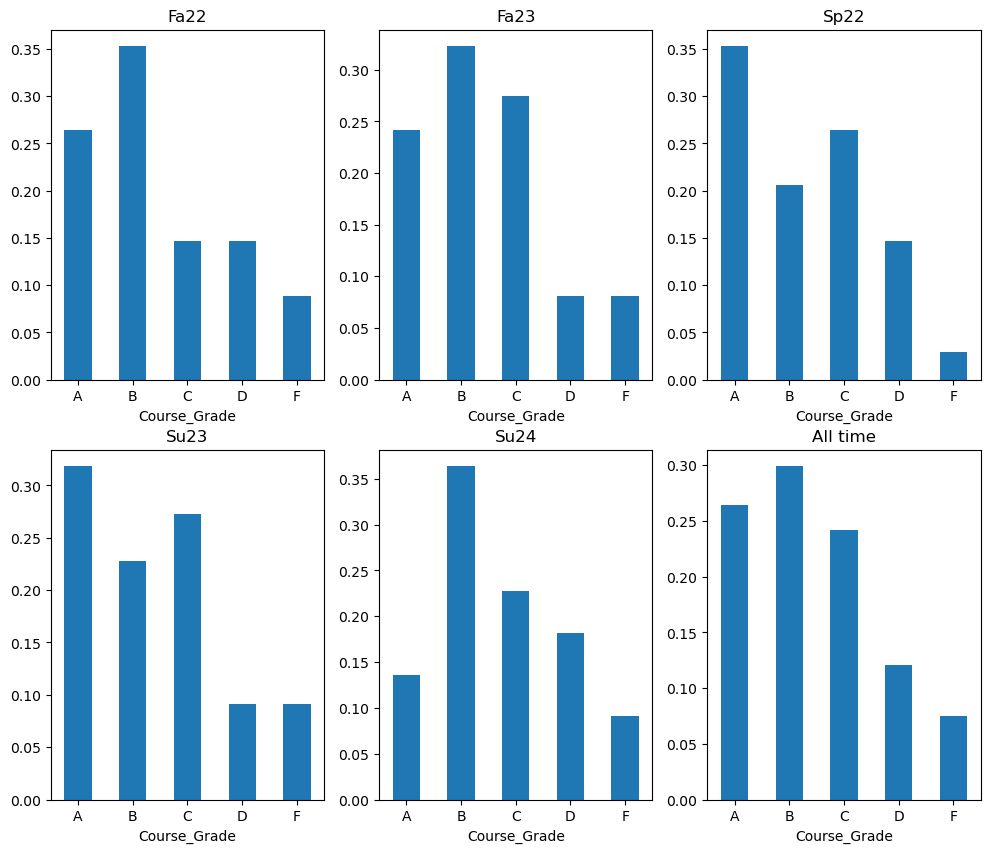

In [58]:
fig, axes = plt.subplots(2, 3)

for i, semester in enumerate(semesters):
    grade_hists.loc[semester].apply(lambda x: x/grade_hists.loc[semester].sum()).plot(kind='bar', rot=0, ax=axes[math.floor(i/3), i%3], title=semester, figsize=(12,10))

total_grade_hist.apply(lambda x: x/grade_hists.sum()).plot(kind='bar', rot=0, ax=axes[1,2], title='All time', figsize=(12,10))

<Axes: title={'center': 'All time'}, xlabel='Course_Grade'>

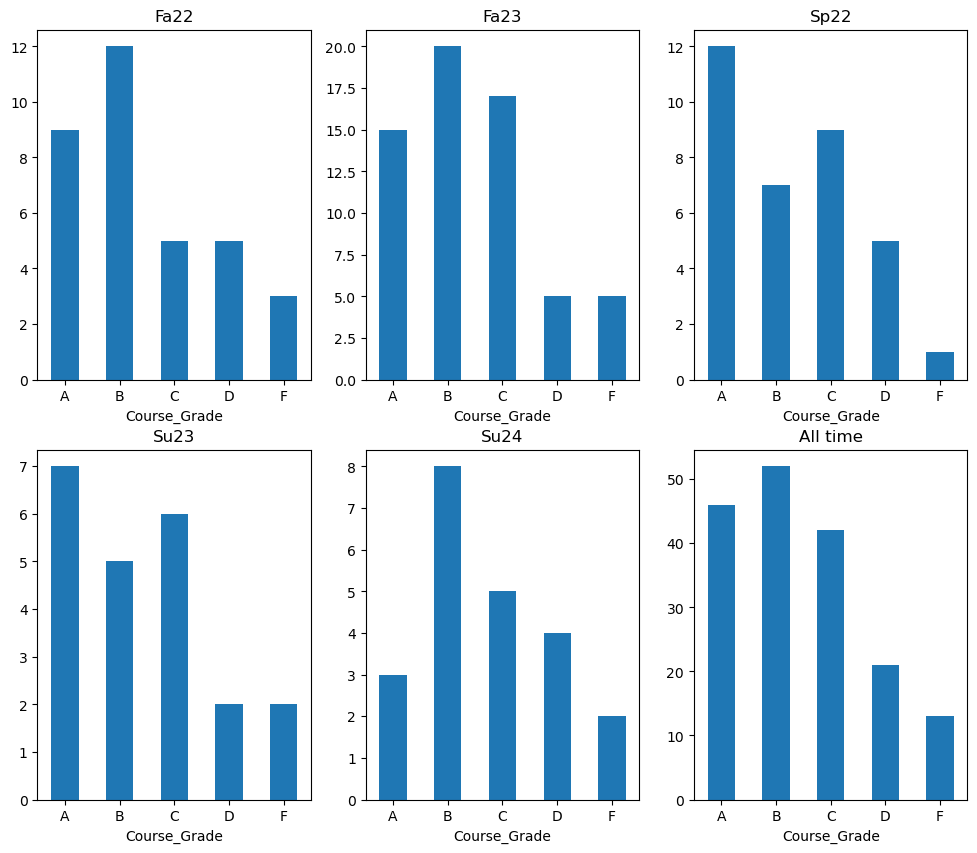

In [59]:

semesters = grade_data.groupby('Semester').Course_Grade.value_counts(sort=False).index.unique(level='Semester').tolist()

grade_hists = grade_data.groupby('Semester').Course_Grade.value_counts(sort=False)
total_grade_hist = grade_data.Course_Grade.value_counts().sort_index()

fig, axes = plt.subplots(2, 3)
for i, semester in enumerate(semesters):
    grade_hists.loc[semester].plot(kind='bar', rot=0, ax=axes[math.floor(i/3),i%3], title=semester, figsize=(12,10))
  
total_grade_hist.plot(kind='bar', rot=0, ax=axes[1,2], title='All time', figsize=(12,10))
#plt.show()

In [60]:
#Run this cell if using all every semester's data as training data (not just data prior to Fall 2023)
#Define and train classifier

X_train, X_test, y_train, y_test = train_test_split(X.iloc[:152], y.iloc[:152], random_state=0)

lr = LogisticRegression(random_state=0)
params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}#, 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]} 
clf = GridSearchCV(lr, params, scoring = 'recall')
clf.fit(X_train, y_train)

y_prob = clf.best_estimator_.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.6)*1

print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(roc_auc_score(y_test, y_prob))

0.8157894736842105
1.0
0.8157894736842105
0.9769585253456221


In [61]:
#run this cell if using data prior to Fall 2023 to predict outcomes in Fall 2023
#Define and train classifier

#Choose the features to use for prediction
X_train = X.iloc[:90]
#X = early_data[['M1_rel_ave', 'Quiz Avg']].iloc[:90]

#y is the target vector: 0 if the student failed, 1 if they passed
y_train = y.iloc[:90]

#Pick out data from the Fall 2023 semester
X_test = X.loc[early_data['Semester'] == 'Fa23']
#X_fa23 = early_data[['M1_rel_ave', 'Quiz Avg']].iloc[90:]
y_test = y.loc[grade_data['Semester'] == 'Fa23']

#svc = SVC(probability=True, random_state=0)
lr = LogisticRegression(random_state=0, C=10)
#params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10], 'gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10]} 
params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]} 
#clf = GridSearchCV(lr, params, scoring = 'recall')
lr.fit(X_train, y_train)


y_prob = lr.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.65)*1

print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(roc_auc_score(y_test, y_prob))


0.8225806451612904
0.8076923076923077
0.9767441860465116
0.9211538461538462


In [62]:
early_data['Semester'].iloc[150:152]

150    Fa23
151    Fa23
Name: Semester, dtype: object

In [63]:
#run this cell if using data prior to Summer 2024 to predict outcomes in Summer 2024
#Define and train classifier

#Choose the features to use for prediction
X_train = X.iloc[:152]
#X = early_data[['M1_rel_ave', 'Quiz Avg']].iloc[:90]

#y is the target vector: 0 if the student failed, 1 if they passed
y_train = y.iloc[:152]

#Pick out data from the Fall 2023 semester
X_test = X.loc[early_data['Semester'] == 'Su24']
#X_fa23 = early_data[['M1_rel_ave', 'Quiz Avg']].iloc[90:]
y_test = y.loc[grade_data['Semester'] == 'Su24']

#svc = SVC(probability=True, random_state=0)
lr = LogisticRegression(random_state=0, C=10)
#params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10], 'gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10]} 
params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]} 
#clf = GridSearchCV(lr, params, scoring = 'recall')
lr.fit(X_train, y_train)


y_prob = lr.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.45)*1

print(y_prob)


[0.89670644 0.98992998 0.98615447 0.1008462  0.58644579 0.98508868
 0.88187145 0.93019089 0.78385896 0.68068652 0.84505921 0.98099059
 0.97872445 0.40822633 0.95998817 0.99550418 0.96839839 0.86407906
 0.94763237 0.9411676  0.76107327 0.99446427]


In [64]:
lr.coef_

array([[0.16624588, 8.21664788, 3.64238824]])

In [65]:
#Collect and plot results
results = pd.concat([y_test, pd.Series(y_pred, index = y_test.index)], axis=1)
results = results.rename(columns = {'Course Grade': "Pass", 0: 'Predict Pass'})
results.insert(2, 'False Pos', (results['Pass'] == 0)*(results['Predict Pass']==1)*1)
results.insert(2, 'False Neg', (results['Pass'] == 1)*(results['Predict Pass']==0)*1)

train_data = pd.concat([X_train, y_train], axis = 1).rename(columns = {'Course Grade': 'Pass'})
pred_data = pd.concat([X_test, results], axis = 1)
pred_wrong = pred_data[(pred_data['False Neg']==1)+(pred_data['False Pos']==1)]
print(pred_wrong)

c_dict_train = {0: 'tab:red', 1: 'tab:blue'}
c_dict_pred = {0: 'lime', 1: 'darkorange'}

c_train = [c_dict_train[x] for x in train_data['Pass'].values]
c_pred = [c_dict_train[x] for x in pred_data['Predict Pass'].values]
c_pred_wrong = [c_dict_pred[x] for x in pred_wrong['Predict Pass'].values]

plt.scatter(train_data['Midterm1'], train_data['Quiz Avg'], c = c_train, alpha = 0.5, s = 50)
plt.scatter(pred_data['Midterm1'], pred_data['Quiz Avg'], c = c_pred, alpha = 1, s = 60, marker = '*')
plt.scatter(pred_wrong['Midterm1'], pred_wrong['Quiz Avg'], c = c_pred_wrong, alpha = 1, s = 80, marker = '*')
plt.xlabel('Midterm 1 Score')
plt.ylabel('Quiz average')

KeyError: 'Pass'

[[0.9979702  0.99788076 0.9977874  ... 0.08996921 0.08649376 0.08314029]
 [0.99794898 0.99785861 0.99776427 ... 0.08911982 0.08567408 0.08234953]
 [0.99792755 0.99783624 0.99774091 ... 0.08827766 0.08486145 0.08156562]
 ...
 [0.9844081  0.98373085 0.9830247  ... 0.01253636 0.0120126  0.01151048]
 [0.98424737 0.98356326 0.98284996 ... 0.01240804 0.01188958 0.01139253]
 [0.98408502 0.98339398 0.98267346 ... 0.01228101 0.0117678  0.01127578]]


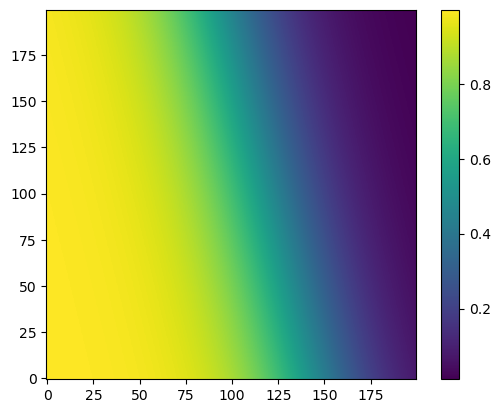

In [ ]:
import numpy as np
N = 200
x = np.linspace(0, 1, N)
x1, x2 = np.meshgrid(x, x)
P_prob = np.zeros((N,N))
P_pred = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        dat = pd.DataFrame(data = {'Midterm1': [x[j]], 'Quiz Avg': [x[i]]})
        
        P_prob[i, j] = np.squeeze(clf.predict_proba(dat)[:,1])
        P_pred[i, j] = np.squeeze((clf.predict_proba(dat)[:,1]>0.5)*1)

print(P_prob)
plt.imshow(P_prob, origin = 'lower')
plt.colorbar()
plt.show()

[0.72361809 0.72864322 0.73366834 0.73869347 0.74371859 0.74874372
 0.75376884 0.75879397 0.7638191  0.76884422 0.77386935 0.77889447
 0.7839196  0.78894472 0.79396985 0.79899497 0.8040201  0.80904523
 0.81407035 0.81909548 0.8241206  0.82914573 0.83417085 0.83919598
 0.84422111 0.84924623 0.85427136 0.85929648 0.86432161 0.86934673
 0.87437186 0.87939698 0.88442211 0.88944724 0.89447236 0.89949749
 0.90452261 0.90954774 0.91457286 0.91959799 0.92462312 0.92964824
 0.93467337 0.93969849 0.94472362 0.94974874 0.95477387 0.95979899
 0.96482412 0.96984925 0.97487437 0.9798995  0.98492462 0.98994975
 0.99497487 1.        ]


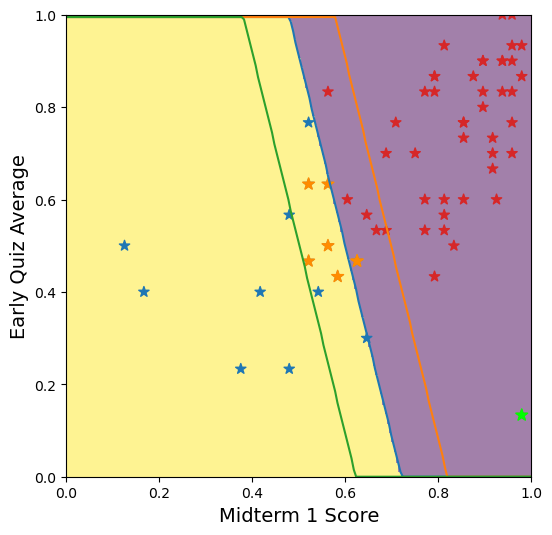

In [ ]:
curve50 = np.argmin(abs(P_prob-0.5), axis = 0)
print(x[curve50==0])
curve30 = np.argmin(abs(P_prob-0.3), axis = 0)
curve70 = np.argmin(abs(P_prob-0.7), axis = 0)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(P_pred, origin = 'lower', alpha = 0.5, extent=[0,1,0,1], interpolation='none', aspect = 'auto')
#plt.scatter(train_data['Midterm1'], train_data['Quiz Avg'], c = c_train, alpha = 0.5, s = 50)
plt.scatter(pred_data['Midterm1'], pred_data['Quiz Avg'], c = c_pred, alpha = 1, s = 60, marker = '*')
plt.scatter(pred_wrong['Midterm1'], pred_wrong['Quiz Avg'], c = c_pred_wrong, alpha = 1, s = 80, marker = '*')
plt.plot(x, curve50/200)
plt.plot(x, curve30/200)
plt.plot(x, curve70/200)
#plt.colorbar()
plt.xlabel('Midterm 1 Score', fontsize = 14)
plt.ylabel('Early Quiz Average', fontsize = 14)
plt.show()

In [ ]:
print(pd.concat([X_test, pd.Series(y_prob, index = X_test.index)], axis = 1))

     Midterm1  Quiz Avg         0
90   0.979167  0.133333  0.076017
91   0.937500  0.900000  0.023453
92   0.979167  0.933333  0.015422
93   0.375000  0.233333  0.923415
94   0.958333  1.000000  0.016056
..        ...       ...       ...
147  0.925000  0.600000  0.047446
148  0.666667  0.533333  0.345217
149  0.645833  0.566667  0.370490
150  0.812500  0.533333  0.130785
151  0.604167  0.600000  0.440048

[62 rows x 3 columns]


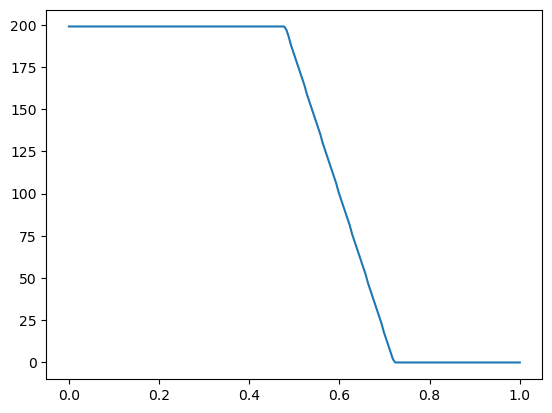

In [ ]:
curve50 = np.argmin(abs(P_prob-0.5), axis = 0)
plt.plot(x, curve50)

In [ ]:
clf.predict_proba(pd.DataFrame({'Midterm1': [0.685185], 'Quiz Avg': [0.287778]}))[:,1]
clf.predict_proba(pd.DataFrame({'Midterm1': [0.7], 'Quiz Avg': [0.3]}))[:,1]

array([0.39103538])

In [ ]:
print(type(P_prob))

<class 'numpy.ndarray'>


<Axes: ylabel='Feature'>

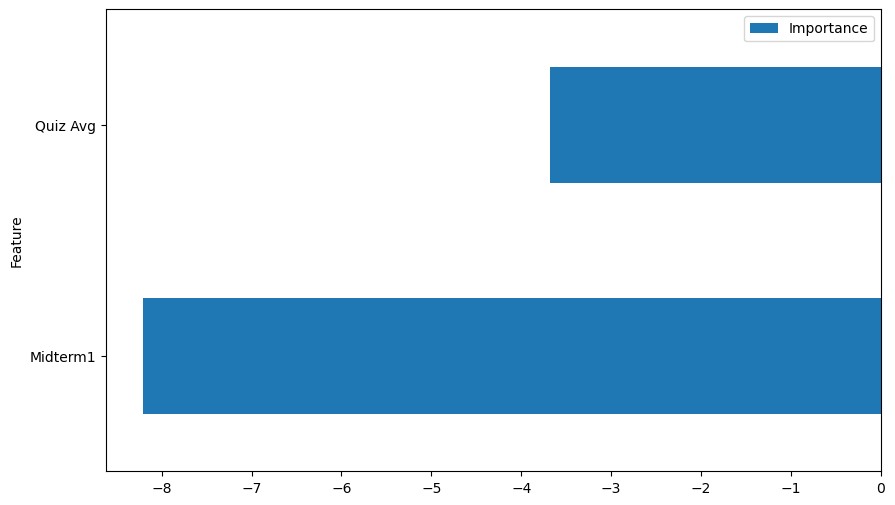

In [ ]:
feature_importance = pd.DataFrame({'Feature': ['Midterm1', 'Quiz Avg'], 'Importance': lr.coef_[0]}).sort_values('Importance')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 

In [ ]:
lr.coef_

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [ ]:
pass_probs = grade_data[['Semester', 'Midterm1',  'Course Grade']]
pass_probs.insert(2, column = 'Quiz Avg', value=early_data['Quiz Avg'])
pass_probs.insert(3, column = 'Pass prob', value=lr.predict_proba(X)[:,0])

In [ ]:
pass_probs.head()

,Semester,Midterm1,Quiz Avg,Pass prob,Course Grade
0,Sp22,1.000,0.666667,0.985507,B
1,Sp22,0.725,0.533333,0.813290,C
2,Sp22,0.900,0.900000,0.986025,C
3,Sp22,0.575,0.700000,0.701170,D
4,Sp22,0.700,0.766667,0.893235,D


In [ ]:
lr.predict_proba(X)

array([[0.98550664, 0.01449336],
       [0.81329012, 0.18670988],
       [0.98602513, 0.01397487],
       [0.70117005, 0.29882995],
       [0.89323507, 0.10676493],
       [0.86320171, 0.13679829],
       [0.63105938, 0.36894062],
       [0.93445769, 0.06554231],
       [0.98948464, 0.01051536],
       [0.99107304, 0.00892696],
       [0.99451348, 0.00548652],
       [0.98606536, 0.01393464],
       [0.85277515, 0.14722485],
       [0.97450909, 0.02549091],
       [0.93934341, 0.06065659],
       [0.99028293, 0.00971707],
       [0.99570108, 0.00429892],
       [0.99269622, 0.00730378],
       [0.92940017, 0.07059983],
       [0.95017459, 0.04982541],
       [0.99472684, 0.00527316],
       [0.80670319, 0.19329681],
       [0.92377853, 0.07622147],
       [0.97908051, 0.02091949],
       [0.98761715, 0.01238285],
       [0.39688322, 0.60311678],
       [0.90086766, 0.09913234],
       [0.98656413, 0.01343587],
       [0.60952381, 0.39047619],
       [0.86320171, 0.13679829],
       [0.